In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:


'''SplitData function - used to divide a variable, according to the number of divided groups,
return a list of dividing point values'''
def SplitData(df,col,numOfSplit, special_attribute=[]):
    df2 = df.copy()
    if special_attribute != []:
        df2 = df2.loc[~df2[col].isin(special_attribute)]
    N = len(df2)
    n = int(N/numOfSplit)
    SplitPointIndex = [i*n for i in range(1,numOfSplit)]
    rawValues = sorted(list(df[col]))
    SplitPoint = [rawValues[i] for i in SplitPointIndex]
    SplitPoint = sorted(list(set(SplitPoint)))
    return SplitPoint


'''BinBadRate function - group by a variable, calculate the bad sample rate of each group after grouping, 
return a dictionary form, a data frame, and the overall bad sample rate (optional)'''

def BinBadRate(df,col,target,grantRateIndicator=0):
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis =1)
    dicts = dict(zip(regroup[col], regroup['bad_rate']))
    
    if grantRateIndicator==0:
        return (regroup) #(dicts) , 
    else:
        N = sum(regroup['total'])
        B = sum(regroup['bad'])
        overallRate = B * 1.0/ N
        return (dicts, regroup, overallRate)

    
'''AssignGroup function - according to the grouped division point list, 
match each value of a variable to be binned before binning to form a mapping of the corresponding bins
'''    
def AssignGroup(x, bin):
    N = len(bin)
    if x<=min(bin):
        return min(bin)
    elif x>max(bin):
        return 10e10
    else:
        for i in range(N-1):
            if bin[i] < x <= bin[i+1]:
                return bin[i+1]

'''AssignBin function - bins and numbers each value of a column'''            
def AssignBin(x, cutOffPoints, special_attribute=[]):
    numBin = len(cutOffPoints) + 1 + len(special_attribute)
    if x in special_attribute:
        i = special_attribute.index(x) +1
        return 'Bin{}'.format(0-i)
    if x <= cutOffPoints[-1]:
        return 'Bin {}'.format(numBin-1)
    else:
        for i in range(0,numBin-1):
            if cutOffPoints[i] < x <= cutOffPoints[i+1]:
                return 'Bin {}'.format(i+1)


    

'''UnsupervisedSplitBin function - grouping numerical variables, 
the grouping is based on equal frequency and equal distance, and finally returns the list of division points
'''    
def UnsupervisedSplitBin(df,var,numOfSplit = 5, method = 'equal freq'):
    if method == 'equal fred':
        N = df.shape[0]
        n = N / numOfSplit
        splitPointIndex = [i * n for i in range(1, numOfSplit)]
        rawValues = sorted(list(df[var]))
        splitPoint = [rawValues[i] for i in splitPointIndex]
        splitPoint = sorted(list(set(splitPoint)))
        return splitPoint
    else:
        var_max, var_min = max(df[var]), min(df[var])
        interval_len = (var_max - var_min)*1.0/numOfSplit
        splitPoint = [var_min + i*interval_len for i in range(1, numOfSplit)]
        return splitPoint

    
'''BadRateEncoding function - used to encode categorical variables with BadRate, 
and return the bad sample rate corresponding to each value of the column
'''    
def BadRateEncoding(df,col,target):
    regroup = BinBadRate(df, col, target, grantRateIndicator=0)[1]
    br_dict = regroup[[col,'bad_rate']].set_index([col]).to_dict(orient='index')
    for k, v in br_dict.items():
        br_dict[k] = v['bad_rate']
    BadRateEncoding = df[col].map(lambda x: br_dict[x])
    return {'encoding':BadRateEncoding, 'bad_rate':br_dict}

'''CalcWOE function - perform WOE calculation and IV value calculation on the binning result of a variable, 
and finally return the WOE value corresponding to each box of the variable and the IV value of the variable
'''
def CalcWOE(df, col, target):
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total']-regroup['bad']
    G = N-B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0/G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt), axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict,'IV':IV}
                         


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc

In [4]:
data = pd.read_csv(".../LoanStats_2019Q1.csv")
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,123,124,125,128,129,130,133) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20475.0,20475.0,20475.0,36 months,20.00%,760.93,D,D2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10000.0,10000.0,10000.0,36 months,8.81%,317.12,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,6500.0,6500.0,6475.0,36 months,8.81%,206.13,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,12000.0,12000.0,12000.0,36 months,16.40%,424.26,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,16500.0,16500.0,16500.0,36 months,8.19%,518.50,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
loan_status = data['loan_status'].value_counts()
loan_status

Fully Paid            87393
Current               14024
Charged Off           13494
In Grace Period         358
Late (31-120 days)      315
Late (16-30 days)        89
Default                   2
Name: loan_status, dtype: int64

In [6]:
data['loan_status']=data['loan_status'].replace(['Fully Paid','In Grace Period','Late (31-120 days)','Late (16-30 days)','Charged Off','Default'],
                                               ['0','1','1','1','1','1'])
data = data[data['loan_status'].isin(['0','1'])]
data['loan_status'] 
data['loan_status'] = data['loan_status'].astype('int')

In [7]:
#loai bo nhung cot null va irrelevant
null_cols = data.isna().sum().sort_values(ascending=False)/float(data.shape[0])
null_cols[null_cols > .3]

data = data.dropna(thresh=data.shape[0]* .7, axis=1)
names=['sub_grade','emp_title','pymnt_plan','title','zip_code','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
      'last_credit_pull_d','collections_12_mths_ex_med','policy_code','acc_now_delinq','num_tl_120dpd_2m','num_tl_30dpd','hardship_flag','debt_settlement_flag',
      'funded_amnt','funded_amnt_inv','out_prncp_inv','total_pymnt','total_pymnt_inv','out_prncp','total_rec_prncp','total_rec_int']
data=data.drop(names, axis=1)
data=data.drop(data[data['earliest_cr_line'] == '1900/1/0'].index)

In [8]:
data[['emp_length','int_rate','issue_d',
        'delinq_2yrs','revol_bal','total_acc','revol_util','earliest_cr_line']].dtypes

emp_length           object
int_rate             object
issue_d              object
delinq_2yrs         float64
revol_bal           float64
total_acc           float64
revol_util           object
earliest_cr_line     object
dtype: object

In [9]:
#cleaning data
data['int_rate']= data['int_rate'].str.replace('%','').astype('float')
data['revol_util']=data['revol_util'].str.replace('%','').astype('float')

data['emp_length']=data['emp_length'].fillna('0')
data['emp_length']=data['emp_length'].str.replace(' year','')
data['emp_length']=data['emp_length'].str.replace('s','')
data['emp_length']=data['emp_length'].replace(['10+','< 1'],['11','0']).astype('int')

data['income_vs_loan']=data['annual_inc']/data['loan_amnt']
data['delinq_2yrs']=data['delinq_2yrs'].astype('int')
data['revol_bal']=data['revol_bal'].astype('int')
data['total_acc']=data['total_acc'].astype('int')

In [10]:
#thay the cac date thanh cac khoang date
data['issue_d']=pd.to_datetime(data['issue_d'],format='%m/%d/%Y')
data['earliest_cr_line']=pd.to_datetime(data['earliest_cr_line'],format='%m/%d/%Y')
data['mth_interval']=data['issue_d']-data['earliest_cr_line']
data['mth_interval']=data['mth_interval'].apply(lambda x:  round(x.days/30,0))
data['issue_m']=data['issue_d'].apply(lambda x: x.month)
#tax liens all zero nen cung drop
data=data.drop(['issue_d','earliest_cr_line','tax_liens'],axis=1)


In [11]:
na_cols=data.isna().sum()[data.isna().sum() > 0].index.values
print(data[na_cols].dtypes)

'''for col in na_cols:
    mean = data[col].mean()
    data[col] = data[col].fillna(mean, inplace=True)'''

data.fillna(value = data.mean(), inplace=True)

dti                      float64
revol_util               float64
mths_since_rcnt_il       float64
il_util                  float64
all_util                 float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_il_acct       float64
mths_since_recent_bc     float64
mths_since_recent_inq    float64
percent_bc_gt_75         float64
dtype: object


In [12]:
num_features =[]
obj_features =[]
for i in data.columns.values:
    if data[i].dtypes == 'object':
        obj_features.append(i)
    else:
        num_features.append(i)
num_features.remove('loan_status')

#fig,ax = plt.subplots(figsize=(20,20))
#sns.heatmap(data[num_features].corr().round(2))
#cor = data[num_features].corr()[np.abs(data[num_features].corr()) < 0.6]
#cor

In [13]:
loan_1=data.copy()
#loan_1[obj_features]=loan_1[obj_features].apply(LabelEncoder().fit_transform)

data_1=loan_1[loan_1['loan_status'] == 1]
data_0=loan_1[loan_1['loan_status'] == 0]

data_1_train,data_1_test=train_test_split(data_1,test_size=.3,random_state=12)
data_0_train,data_0_test=train_test_split(data_0,test_size=.3,random_state=12)
train=pd.concat([data_1_train,data_0_train])
test=pd.concat([data_1_test,data_0_test])

#train_X=train.drop(['loan_status'],axis=1)
#train_y=train['loan_status']
#test_X=test.drop(['loan_status'],axis=1)
#test_y=test['loan_status']


In [14]:
#tach number va object 
num_features=[]
obj_features=[]
for i in data.columns.values:
    if data[i].dtype == 'object':
        obj_features.append(i)
    else:
        num_features.append(i)
num_features.remove('loan_status')

#train,test=train_test_split(data,test_size=.3,random_state=12)

In [15]:
purpose=BinBadRate(data,'purpose','loan_status')
state=BinBadRate(data,'addr_state','loan_status')
#data['purpose']=purpose['encoding']
#data['addr_state']=state['encoding']

sum(state['total'])/5

20330.2

In [16]:
state_br = state.sort_values('bad_rate').reset_index()
state_br

,index,addr_state,total,bad,bad_rate
0,20,ME,367,37,0.100817
1,48,WV,556,57,0.102518
2,49,WY,194,20,0.103093
3,8,DE,316,33,0.104430
4,7,DC,202,22,0.108911
5,29,NH,540,59,0.109259
6,36,OR,1334,151,0.113193
7,12,ID,356,41,0.115169
8,21,MI,2484,288,0.115942
9,0,AK,224,26,0.116071


In [17]:
dfc = state_br[state_br['total'].cumsum() < 20000]
dfc['addr_state'].values


array(['ME', 'WV', 'WY', 'DE', 'DC', 'NH', 'OR', 'ID', 'MI', 'AK', 'VT',
       'CO', 'WA', 'MT', 'SC', 'RI', 'VA', 'WI'], dtype=object)

In [18]:
x =state_br.iloc[18:,:]
dfc1 = x[x['total'].cumsum() < 20000]
dfc1['addr_state'].values

array(['OH', 'MN', 'NC', 'MO', 'KY', 'UT', 'IL', 'IN', 'GA'], dtype=object)

In [19]:
x1 = state_br.iloc[27:,:]
dfc2 = x1[x1['total'].cumsum() < 20000]
dfc2['addr_state'].values

array(['MA', 'NJ', 'AZ', 'AR', 'TX', 'MD'], dtype=object)

In [20]:
x2 = state_br.iloc[33:,:]
dfc3 = x2[x2['total'].cumsum() < 20000]
dfc3['addr_state'].values

array(['AL', 'CA', 'CT', 'NM', 'TN'], dtype=object)

In [21]:
x3 = state_br.iloc[38:,:]
x3['addr_state'].values

array(['PA', 'LA', 'KS', 'NY', 'MS', 'OK', 'FL', 'NE', 'SD', 'HI', 'ND',
       'NV'], dtype=object)

In [22]:
import scorecardpy as sc

In [23]:
breaks_adj = {'acc_open_past_24mths':[3.0,4,0,8.0]
              ,'all_util':[30.0,40.0,60.0]
              ,'annual_inc':[40000.0,100000.0,170000.0]
              ,'avg_cur_bal':[8000.0,16000.0,36000.0]
              ,'bc_util':[35.0,50.0]
              ,'grade':['A','B','C','D%,%E%,%F%,%G']
              ,'il_util':[45.0,65.0]
              ,'income_vs_loan':[2.5,4.5,8.0]
              ,'inq_last_12m':[1.0,2.0,4.0]
              ,'installment':[200.0,500.0,650.0,1150.0]
              ,'loan_amnt':[10000.0,19000.0]
              ,'max_bal_bc':[6500.0,11500.0,14500.0]
              ,'mo_sin_old_rev_tl_op':[60.0,80.0,140.0,170.0]
              ,'mo_sin_old_il_acct':[50.0,90.0,150.0]
              ,'mth_interval':[70.0,150.0,220.0]
              ,'mths_since_rcnt_il':[5.0,11.0,15.0,18.0,22.0]
              ,'mths_since_recent_bc':[6.0,18.0,30.0,50.0]
              ,'mths_since_recent_inq':[3.0,5.0,7.0]
              ,'num_il_tl':[2.0,3.0,5.0]
              ,'open_rv_24m':[2.0,3.0,5.0]
              ,'revol_bal':[28000.0,37000.0]
              #,'tot_hi_cred_lim':[16000.0,100000.0]
              ,'total_acc':[12.0,16.0]
              ,'total_bax_ex_mort':[45000.0,85000.0,135000.0]
              ,'addr_state':['ME%,%WV%,%WY%,%DE%,%DC%,%NH%,%OR%,%ID%,%MI%,%AK%,%VT%,%CO%,%WA%,%MT%,%SC%,%RI%,%VA%,%WI',
                            'OH%,%MN%,%NC%,%MO%,%KY%,%UT%,%IL%,%IN%,%GA',
                            'MA%,%NJ%,%AZ%,%AR%,%TX%,%MD',
                            'AL%,%CA%,%CT%,%NM%,%TN',
                            'PA%,%LA%,%KS%,%NY%,%MS%,%OK%,%FL%,%NE%,%SD%,%HI%,%ND%,%NV']
              ,'num_accts_ever_120_pd':[1.0,2.0]
              ,'num_bc_sats':[5.0,10.0]
              ,'chargeoff_within_12_mths':[2.0,5.0]
              ,'num_tl_90g_dpd_24m':[4.0,8.0,12.0,16.0]
              ,'delinq_amnt':[13000.0,26000.0,39000.0,52000.0]
              #,'total_bal_il':[250000.0,504000.0,756000.0,1008000.0]
              ,'total_cu_tl':[1.0,3.0,4.0]}


In [24]:
bins = sc.woebin(data, y="loan_status",breaks_list=breaks_adj)

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
addr_state
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 101651 rows and 74 columns in 00:01:04


In [26]:
data['bc_open_to_buy'].value_counts()

16260.619228    1205
0.000000         743
2000.000000       83
5000.000000       79
1000.000000       78
                ... 
68932.000000       1
21282.000000       1
38865.000000       1
54194.000000       1
37425.000000       1
Name: bc_open_to_buy, Length: 38551, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\woebin.py:1225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


{'delinq_amnt': <Figure size 432x288 with 2 Axes>,
 'revol_util': <Figure size 432x288 with 2 Axes>,
 'num_rev_tl_bal_gt_0': <Figure size 432x288 with 2 Axes>,
 'num_tl_90g_dpd_24m': <Figure size 432x288 with 2 Axes>,
 'open_act_il': <Figure size 432x288 with 2 Axes>,
 'acc_open_past_24mths': <Figure size 432x288 with 2 Axes>,
 'delinq_2yrs': <Figure size 432x288 with 2 Axes>,
 'total_bc_limit': <Figure size 432x288 with 2 Axes>,
 'home_ownership': <Figure size 432x288 with 2 Axes>,
 'num_sats': <Figure size 432x288 with 2 Axes>,
 'total_acc': <Figure size 432x288 with 2 Axes>,
 'tot_hi_cred_lim': <Figure size 432x288 with 2 Axes>,
 'grade': <Figure size 432x288 with 2 Axes>,
 'installment': <Figure size 432x288 with 2 Axes>,
 'loan_amnt': <Figure size 432x288 with 2 Axes>,
 'num_bc_tl': <Figure size 432x288 with 2 Axes>,
 'mo_sin_old_rev_tl_op': <Figure size 432x288 with 2 Axes>,
 'all_util': <Figure size 432x288 with 2 Axes>,
 'open_rv_24m': <Figure size 432x288 with 2 Axes>,
 'open_

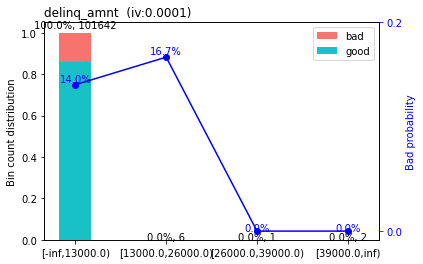

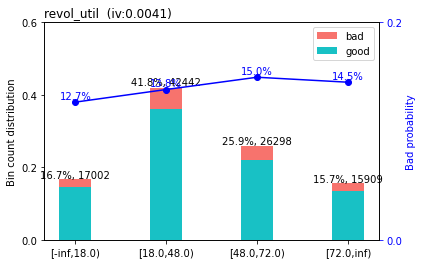

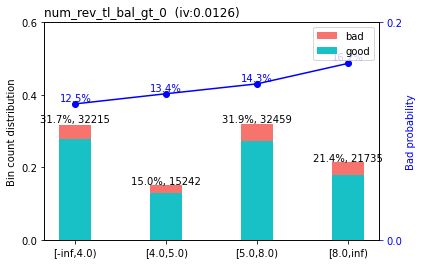

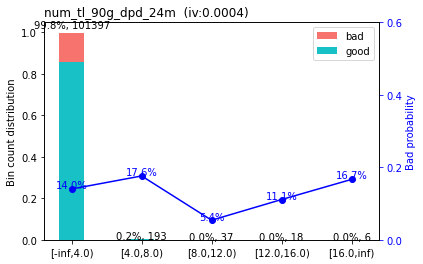

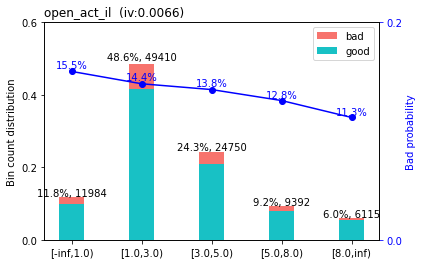

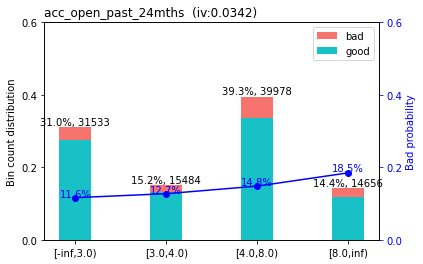

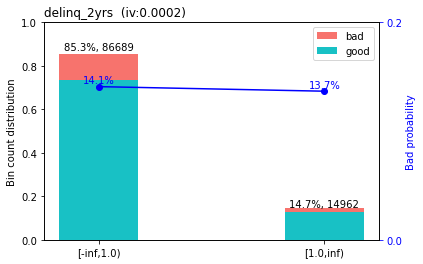

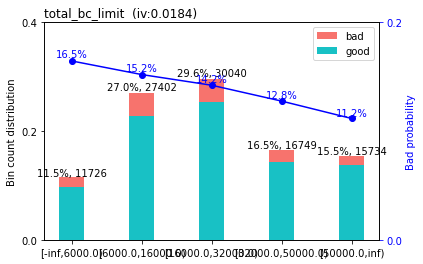

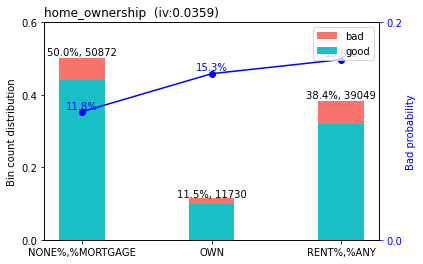

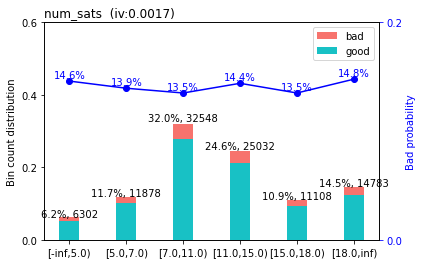

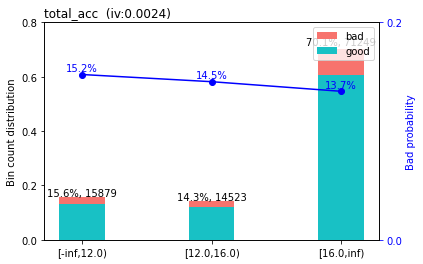

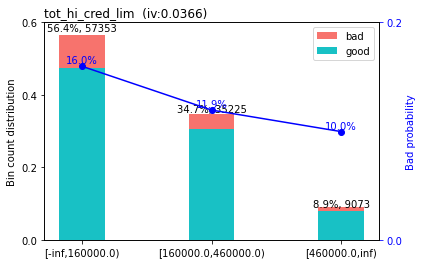

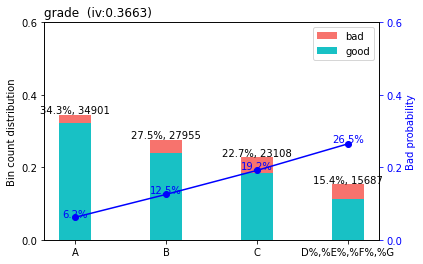

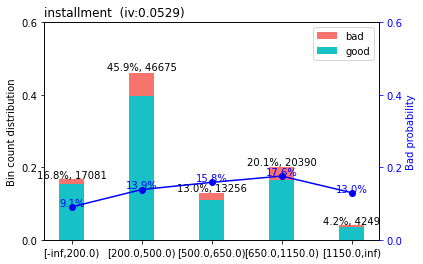

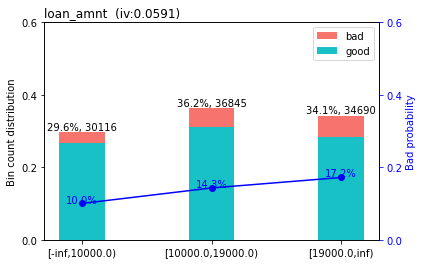

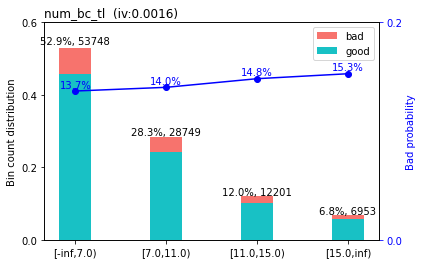

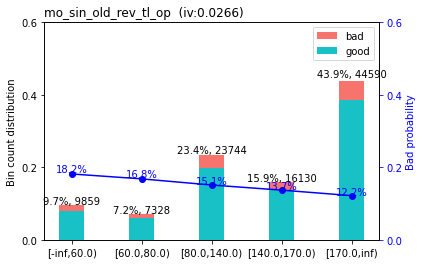

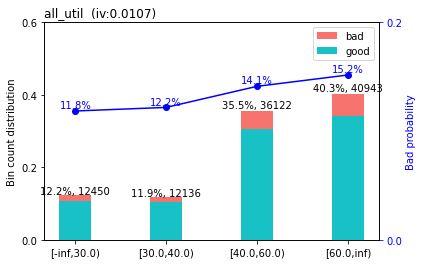

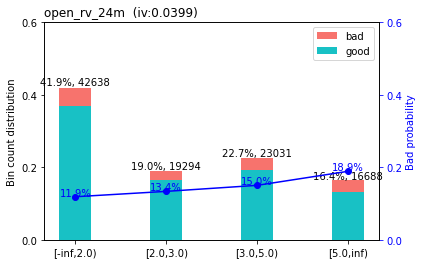

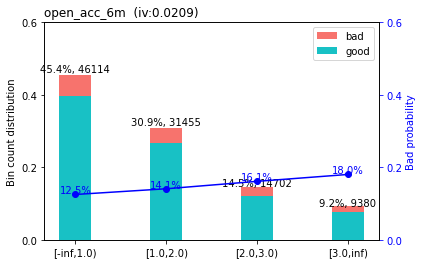

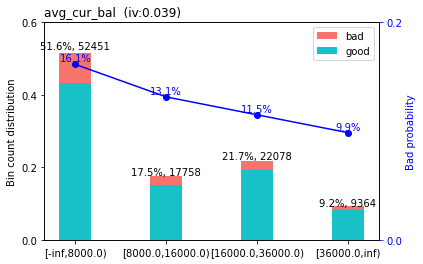

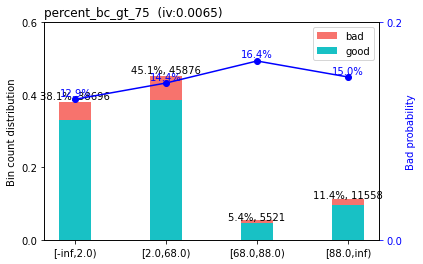

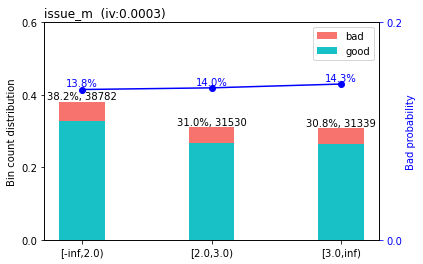

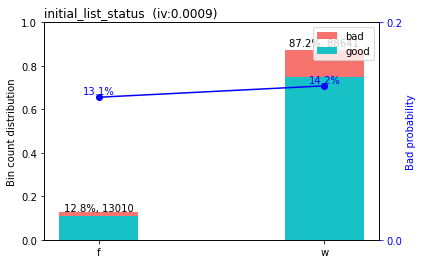

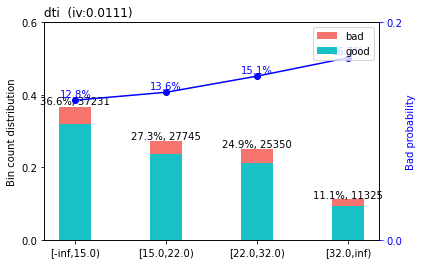

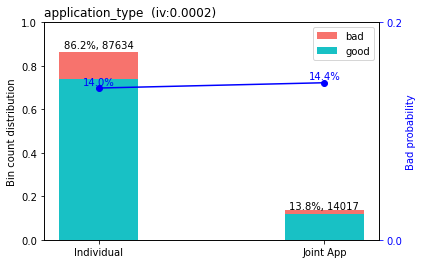

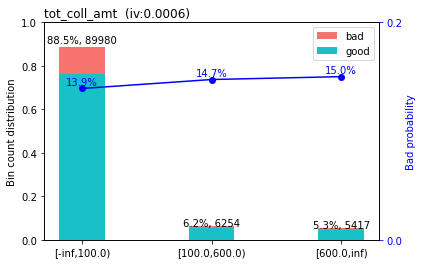

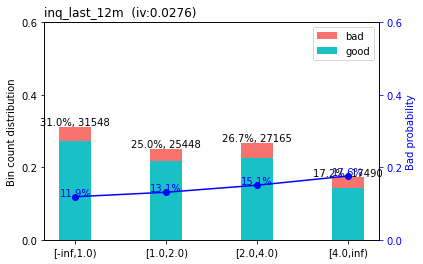

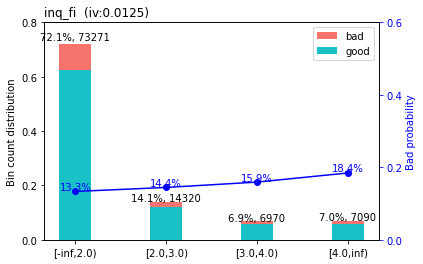

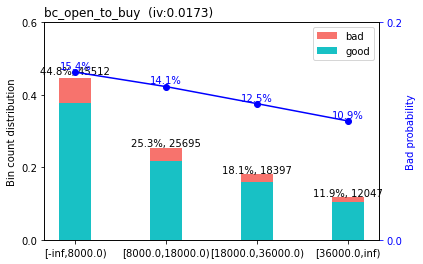

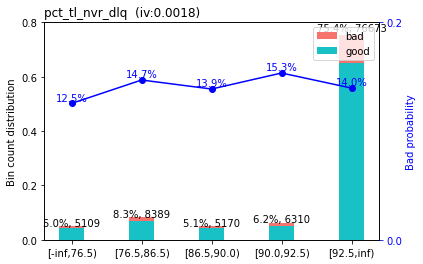

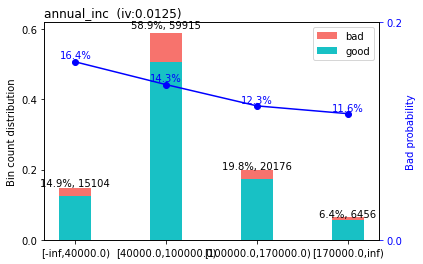

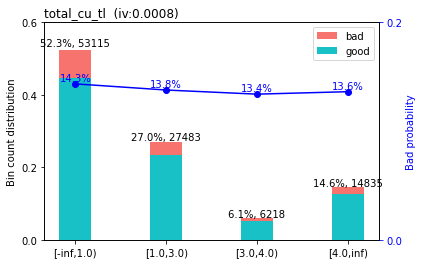

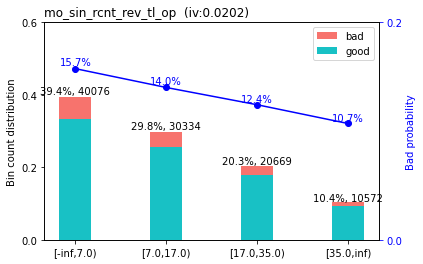

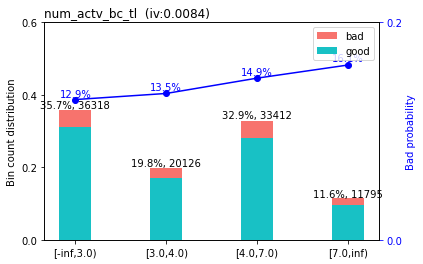

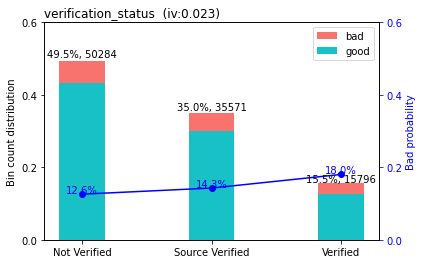

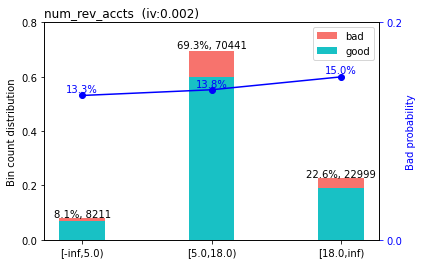

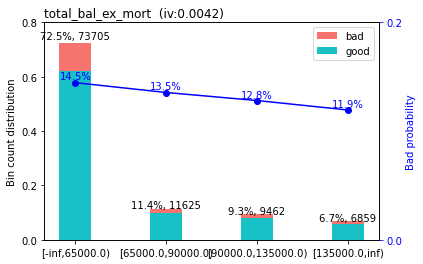

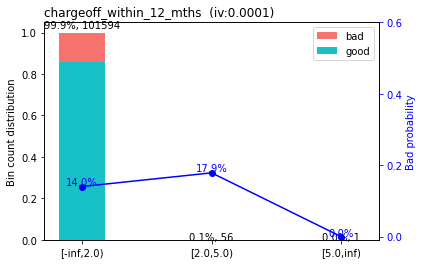

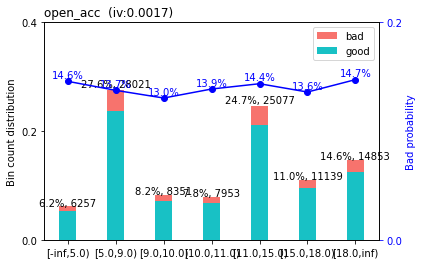

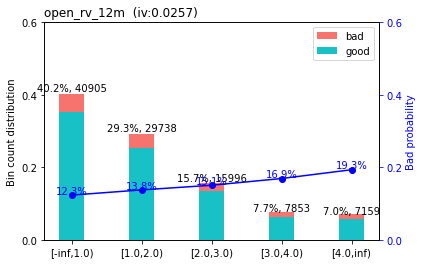

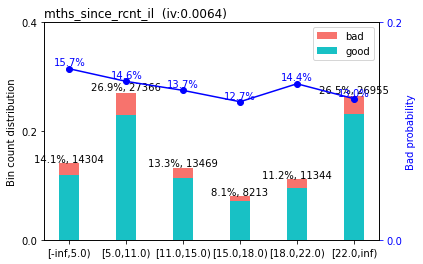

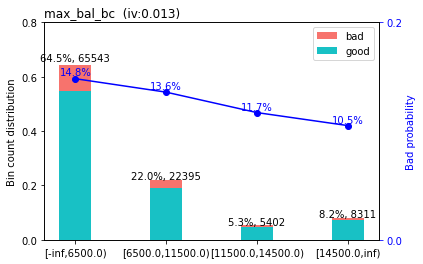

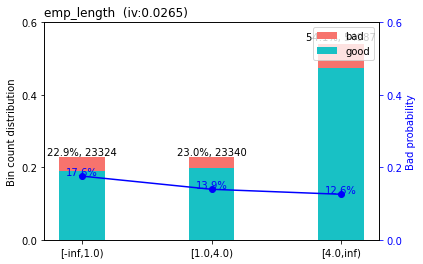

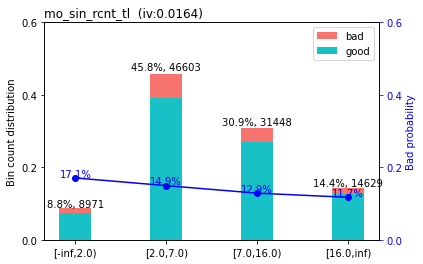

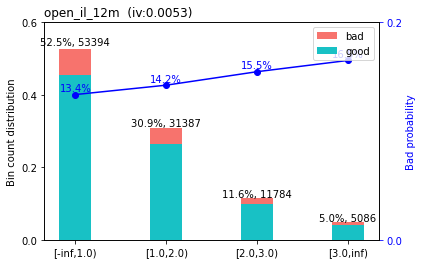

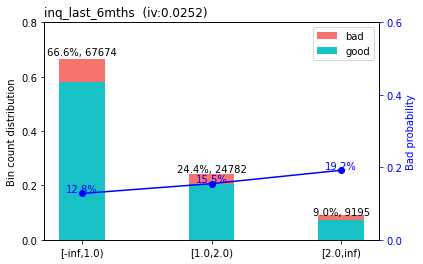

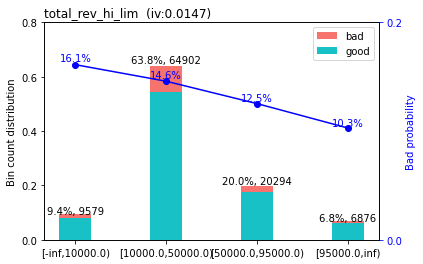

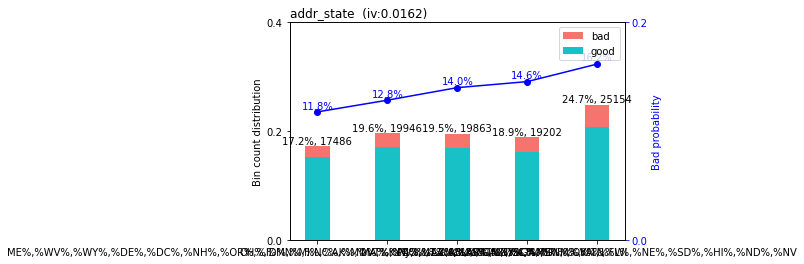

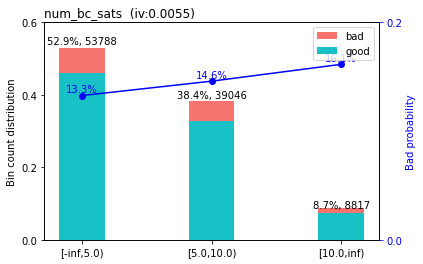

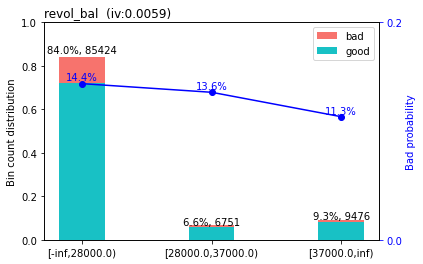

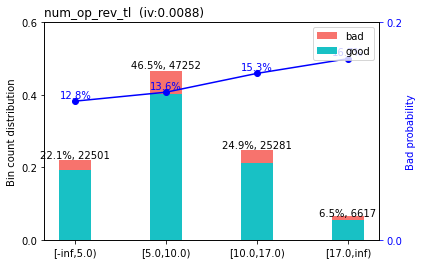

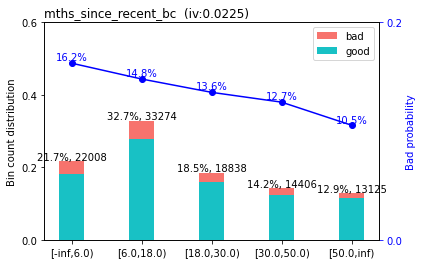

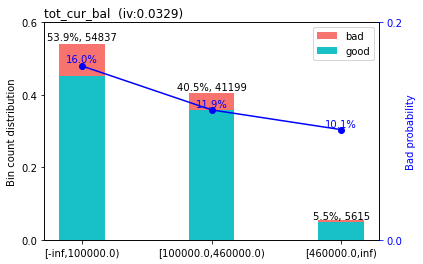

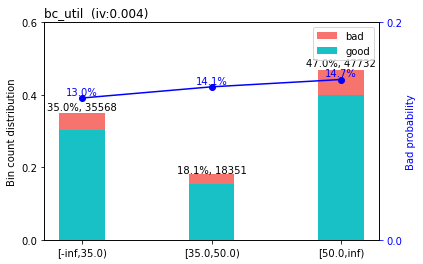

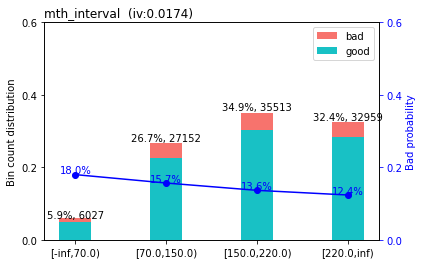

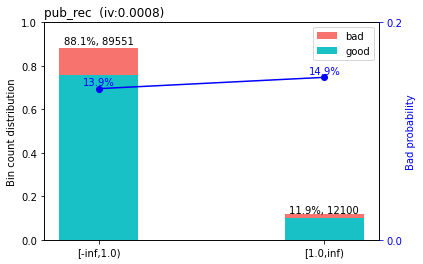

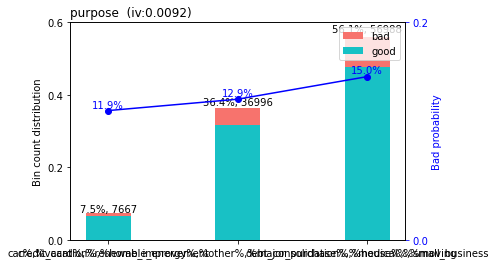

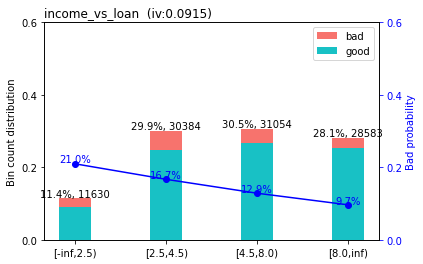

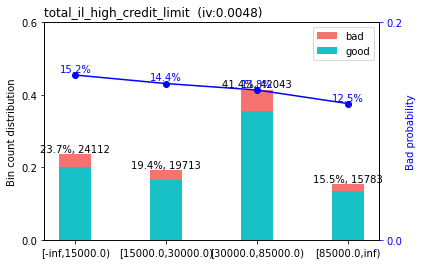

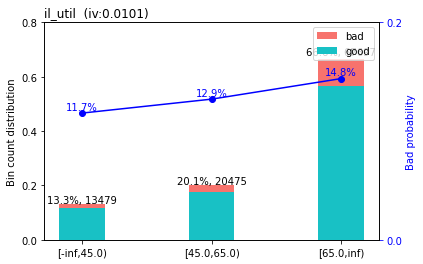

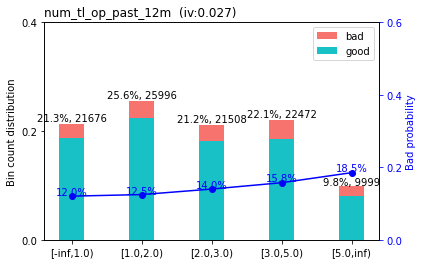

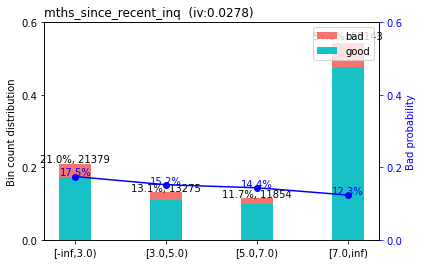

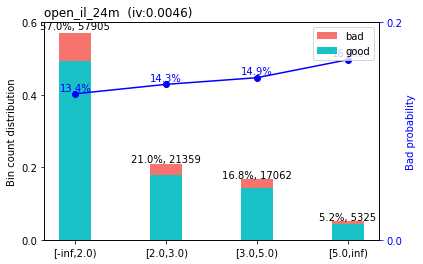

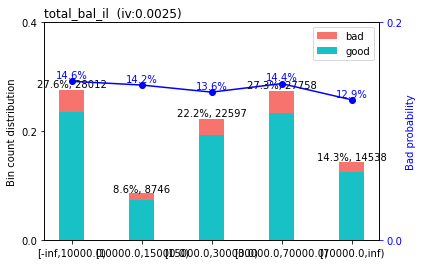

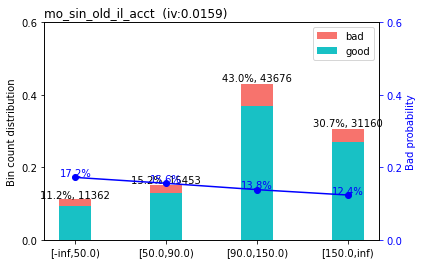

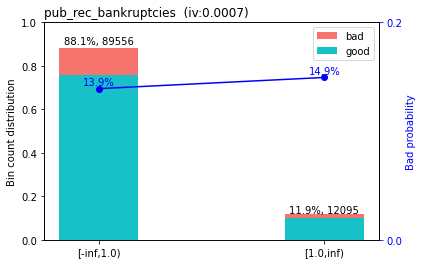

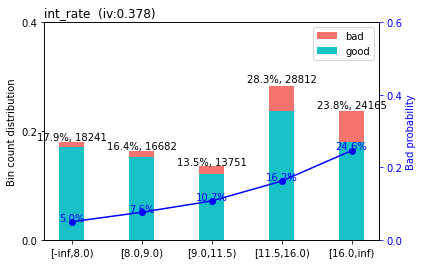

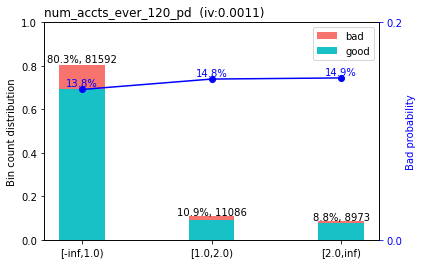

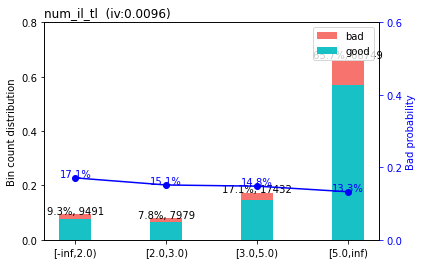

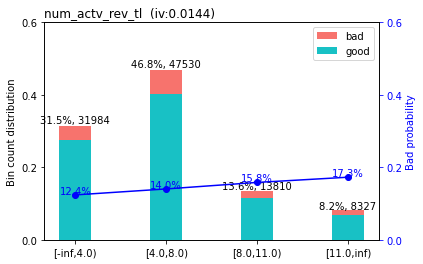

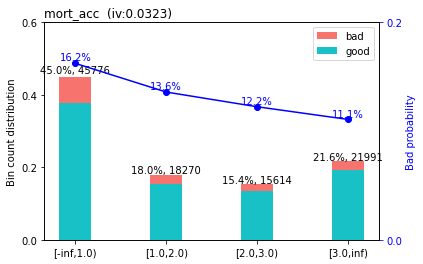

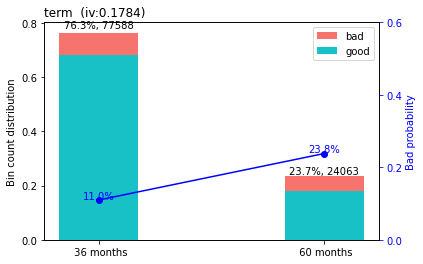

In [27]:
sc.woebin_plot(bins)

In [28]:
#loai bo cac bien ko co trend 

#data = data[list(bins.keys())]
data = data.loc[:, ~data.columns.isin(['installment','num_tl_90g_dpd_24m','chargeoff_within_12_mths',
                                       'num_sats','pct_tl_nvr_dlq','open_acc','delinq_amnt','total_bal_il',
                                      'percent_bc_gt_75','revol_util','mths_since_rcnt_il'])]

BIN TABLE

In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

bin_data = []
data1 = data.loc[:, ~data.columns.isin(['loan_status'])]

for col in data1.columns.values:
    df_bins = bins[col]
    bin_data.append(df_bins)
    bin_data_df = pd.concat(bin_data)

#xem bin table    
bin_data_df = bin_data_df.loc[:,bin_data_df.columns != 'breaks']
bin_data_df

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,is_special_values
0,loan_amnt,"[-inf,10000.0)",30116,0.29627,27094,3022,0.10035,-0.38030,0.03730,0.05909,False
1,loan_amnt,"[10000.0,19000.0)",36845,0.36247,31573,5272,0.14309,0.02320,0.00020,0.05909,False
2,loan_amnt,"[19000.0,inf)",34690,0.34127,28726,5964,0.17192,0.24104,0.02159,0.05909,False
0,term,36 months,77588,0.76328,69060,8528,0.10991,-0.27852,0.05351,0.17839,False
1,term,60 months,24063,0.23672,18333,5730,0.23812,0.65011,0.12489,0.17839,False
0,int_rate,"[-inf,8.0)",18241,0.17945,17334,907,0.04972,-1.13719,0.15322,0.37801,False
1,int_rate,"[8.0,9.0)",16682,0.16411,15415,1267,0.07595,-0.68559,0.06001,0.37801,False
2,int_rate,"[9.0,11.5)",13751,0.13528,12278,1473,0.10712,-0.30741,0.01143,0.37801,False
3,int_rate,"[11.5,16.0)",28812,0.28344,24149,4663,0.16184,0.16851,0.00855,0.37801,False
4,int_rate,"[16.0,inf)",24165,0.23773,18217,5948,0.24614,0.69380,0.14481,0.37801,False


In [47]:
bin_data_df[bin_data_df['variable'] == "mort_acc"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,is_special_values
0,mort_acc,"[-inf,1.0)",45776,0.45033,38347,7429,0.16229,0.17181,0.01413,0.03226,False
1,mort_acc,"[1.0,2.0)",18270,0.17973,15787,2483,0.13591,-0.03662,0.00024,0.03226,False
2,mort_acc,"[2.0,3.0)",15614,0.15360,13703,1911,0.12239,-0.15689,0.00357,0.03226,False
3,mort_acc,"[3.0,inf)",21991,0.21634,19556,2435,0.11073,-0.27024,0.01432,0.03226,False


IV LIST

In [30]:
#xem IV cua cac bien
iv_screen = bin_data_df[['variable','total_iv']].drop_duplicates()
iv_screen

,variable,total_iv
0,loan_amnt,0.05909
0,term,0.17839
0,int_rate,0.37801
0,grade,0.36627
0,emp_length,0.02646
0,home_ownership,0.03588
0,annual_inc,0.01248
0,verification_status,0.02297
0,purpose,0.00925
0,addr_state,0.01617


In [31]:
weak_var = list(iv_screen['variable'][iv_screen['total_iv'] < 0.02].values)
weak_var

['annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'initial_list_status',
 'application_type',
 'tot_coll_amt',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'il_util',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_rcnt_tl',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'pub_rec_bankruptcies',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'mth_interval',
 'issue_m']

In [32]:
#loai bo cac bien IV weak, tru cac bien co lien quan van lay vao
data = data.loc[:, ~data.columns.isin([i for i in weak_var if i not in ('annual_inc','purpose','addr_state',
                                                                       )])]

In [33]:
train, test = sc.split_df(data, 'loan_status').values()

print(train.shape)
print(test.shape)

(71156, 27)
(30495, 27)


In [34]:
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [39]:
train_woe.head()

,loan_status,verification_status_woe,open_rv_12m_woe,emp_length_woe,acc_open_past_24mths_woe,home_ownership_woe,tot_hi_cred_lim_woe,grade_woe,inq_last_6mths_woe,loan_amnt_woe,...,inq_last_12m_woe,income_vs_loan_woe,num_tl_op_past_12m_woe,mths_since_recent_inq_woe,int_rate_woe,annual_inc_woe,open_rv_24m_woe,mort_acc_woe,term_woe,mo_sin_rcnt_rev_tl_op_woe
0,1,0.02075,-0.14858,0.26763,0.06317,-0.20028,0.15169,0.79163,-0.10663,0.24104,...,-0.19011,-0.10074,-0.13475,-0.14679,0.69380,-0.14969,-0.05626,0.17181,-0.27852,-0.13974
1,0,-0.12475,-0.02141,0.26763,0.06317,-0.20028,0.15169,-0.89903,-0.10663,0.02320,...,-0.19011,0.20484,-0.13475,-0.14679,-0.68559,0.18189,0.08032,-0.15689,-0.27852,-0.00131
2,0,0.02075,-0.14858,-0.12740,-0.11260,0.10006,0.15169,-0.89903,0.11650,-0.38030,...,0.26932,-0.42294,-0.17502,0.25915,-0.68559,0.02034,-0.19039,-0.03662,-0.27852,-0.13974
3,0,-0.12475,0.22113,-0.12740,0.32738,-0.20028,-0.18580,0.37331,-0.10663,0.02320,...,0.08318,-0.10074,0.33171,-0.14679,0.69380,0.02034,0.35617,-0.15689,-0.27852,0.13559
6,0,0.29920,0.22113,-0.12740,0.06317,0.19716,0.15169,0.79163,-0.10663,0.02320,...,0.08318,0.20484,0.13637,0.02723,0.69380,0.02034,0.08032,0.17181,0.65011,0.13559


In [36]:
#tách Train/Test thành biến độc lập X và y
y_train = train_woe.loc[:,'loan_status']
X_train = train_woe.loc[:,train_woe.columns != 'loan_status']
y_test = test_woe.loc[:,'loan_status']
X_test = test_woe.loc[:,train_woe.columns != 'loan_status']

In [40]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[ 0.19924539 -0.1666775   1.11176313  0.19798131  0.67654189  0.39190846
   0.39656278  0.23284032  0.67243698  1.00935711  0.51328201  0.30847337
   0.2107775   0.12857339  0.16155922  0.          0.36353551  0.29689183
   0.          0.31209727  0.39656988  0.22088192  0.5070779   0.03469235
   0.59453952 -0.04257212]]
[-1.81782137]


In [42]:
#scorecard
card = sc.scorecard(bins, lr, X_train.columns)
#score
train_score = sc.scorecard_ply(train, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp=None)
test_score = sc.scorecard_ply(test, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp=None)
score = sc.scorecard_ply(data, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp=None)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [64]:
card_data =[]
card_keys = list(card.keys())
for col in card_keys:
    df_card = card[col]
    card_data.append(df_card)
    card_data_df = pd.concat(card_data)

#xem card table    
#card_data_df

,variable,bin,points
0,basepoints,NaN,519.00000
136,verification_status,Not Verified,2.00000
137,verification_status,Source Verified,-0.00000
138,verification_status,Verified,-4.00000
156,open_rv_12m,"[-inf,1.0)",-2.00000
157,open_rv_12m,"[1.0,2.0)",-0.00000
158,open_rv_12m,"[2.0,3.0)",1.00000
159,open_rv_12m,"[3.0,4.0)",3.00000
160,open_rv_12m,"[4.0,inf)",5.00000
171,emp_length,"[-inf,1.0)",-21.00000


In [67]:
card_data_df.drop(card_data_df[card_data_df['variable'] == 'mo_sin_rcnt_rev_tl_op'].index, inplace =True)

In [74]:
card_data_df.to_csv(r'.../card_data_df.csv')

C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


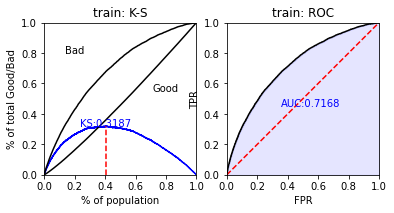

C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


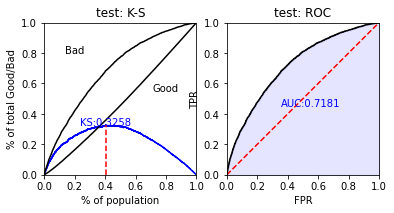

In [48]:
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]
#KS\ROC
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")